# 置信区间
By Delaney Granizo-Mackenzie, Jeremiah Johnson, and Gideon Wulfsohn

Part of the Quantopian Lecture Series:

http://www.quantopian.com/lectures

http://github.com/quantopian/research_public

Notebook released under the Creative Commons Attribution 4.0 License.

样本均值与总体均值

样本均值和总体均值不同。一般来说，我们想知道总体均值，但我们只能计算样本均值。然后用样本均值估计总体均值。我们使用置信区间来确定样本均值估计总体均值的准确性。

## 置信区间

如果我让你估计一个美国女性的平均身高，你可以通过测量10个女性然后估计样本的均值接近总体。让我们试试。

In [1]:
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
# We'll set a seed here so our runs are consistent
np.random.seed(10)

# Let's define some 'true' population parameters, we'll pretend we don't know these.
POPULATION_MU = 64
POPULATION_SIGMA = 5

# Generate our sample by drawing from the population distribution
sample_size = 10
heights = np.random.normal(POPULATION_MU, POPULATION_SIGMA, sample_size)
print(heights) 
mean_height = np.mean(heights)
print('sample mean: ', mean_height) 

[70.65793252 67.57639487 56.27299854 63.95808075 67.10667987 60.3995722
 65.32755793 64.54274263 64.02145715 63.12699895]
sample mean:  64.29904154070394


不幸的是，简单地报告样本均值对我们没有多大帮助，因为我们不知道它与总体均值的关系。为了理解它们之间的关系，我们可以看看样本中有多少方差。较大的方差表明不稳定性和不确定性。

In [3]:
print('sample standard deviation: ', np.std(heights)) 

sample standard deviation:  3.759878018454642


这对我们仍然没有太大帮助，要真正理解样本均值和总体均值的关系我们需要计算一个标准误差。标准误差是对样本均值方差的度量。

#### 注意
计算一个标准误差涉及到假设你抽样的方式是无偏的，数据是正态且独立的。如果违反了这些条件，您的标准错误将是错误的。有很多测试和修正的方法。

标准误差的公式是.

$$SE = \frac{\sigma}{\sqrt{n}}$$

其中$\sigma$为样本标准差，$n$为样本数量。

In [4]:
SE = np.std(heights) / np.sqrt(sample_size)
print( 'standard error: ', SE)

standard error:  1.1889778262717268


scipy的stats库中有一个用于计算标准错误的函数。请注意，该函数默认情况下包含一个通常不需要的自由度校正(对于足够大的样本，它实际上是不相关的)。您可以通过将参数ddof设置为0来忽略校正。

In [5]:
stats.sem(heights, ddof=0)

1.1889778262717268

假设我们的数据是正态分布的，我们可以用标准误差来计算置信区间。为了做到这一点，我们首先设定我们想要的置信水平，比如说95%，然后我们确定有多少个标准差包含95%的质量。结果是95%的质量在-1.96和1.96之间是标准正态分布。当样本足够大(通常以> 30为阈值)时，应用中心极限定理，可以安全地假设正态性;如果样本量较小，较安全的方法是使用具有适当指定自由度的$t$-分布。计算这些值的实际方法是使用累积分布函数(CDF)。如果您不熟悉CDFs、逆CDFs和它们的配套PDFs，您可以阅读它们的相关信息[这里](https://en.wikipedia.org/wiki/Probability_density_function)和[这里](https://en.wikipedia.org/wiki/Cumulative_distribution_function)。查看[这里](https://en.wikipedia.org/wiki/Student%27s_t-distribution)获取关于$t$-分布的信息。我们可以使用Python函数之一来检查95%这个数字。

注意:在应用中心极限定理时要小心，然而，因为金融中的许多数据集从根本上不是正态的，随意应用该定理或不注意细节是不安全的。

我们可以看到95%的质量界限。

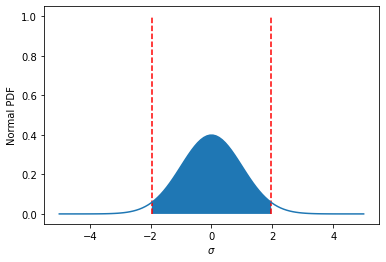

In [6]:
# Set up the x axis
x = np.linspace(-5,5,100)
# Here's the normal distribution
y = stats.norm.pdf(x,0,1)
plt.plot(x,y)

# Plot our bounds
plt.vlines(-1.96, 0, 1, colors='r', linestyles='dashed')
plt.vlines(1.96, 0, 1, colors='r', linestyles='dashed')

# Shade the area
fill_x = np.linspace(-1.96, 1.96, 500)
fill_y = stats.norm.pdf(fill_x, 0, 1)
plt.fill_between(fill_x, fill_y)

plt.xlabel('$\sigma$')
plt.ylabel('Normal PDF');

### 一个技巧

现在，我们可以计算一个区间而不是在没有任何正确概率的情况下报告我们的样本均值，我们可以更确信总体均值在这个区间内。为此，我们取样本均值$\mu$并报告$\left(\mu- 1.96SE， \mu+1.96SE\right)$。

这是可行的，因为假设正态分布，95%的概率区间包含总体均值。

### 敏锐:
在任何给定的情况下，估计值的真实值和置信区间的界限是固定的。说“全国女性平均身高在63到65英寸之间，有95%的可能性”是不正确的，但不幸的是，这是一个非常普遍的误解。相反，95%是指在95%置信区间的多次计算中，95%情况下的真实值都在区间内(假设对置信区间进行了正确校准，我们将在后面讨论)。但事实上，对于单个样本和由它计算出的单个置信区间，我们无法评估该区间包含总体均值的概率。下面的可视化演示了这一点。

在下面的代码块中，有两件事需要注意。首先，虽然样本容量足够大，可以假设为正态分布，但我们使用的是$t$-分布，只是为了演示它是如何使用的。其次，需要的$t$-值(类似于上面使用的$\pm1.96$)是由累积密度函数的逆函数(sci .stats中的ppf)(即分位数函数)计算出来的。$t$-分布需要额外的参数自由度(d.o.f)，即样本的大小减去1。 

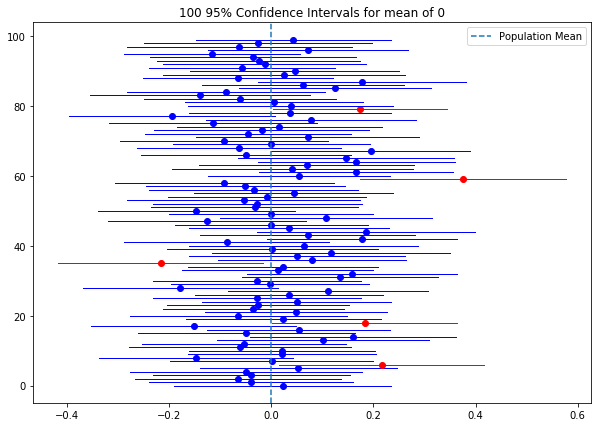

In [11]:
np.random.seed(8309)
n = 100 # number of samples to take
samples = [np.random.normal( size=100) for _ in range(n)]

fig, ax = plt.subplots(figsize=(10, 7))
for i in np.arange(0, n):
    sample_mean = np.mean(samples[i])  # calculate sample mean
    se = stats.sem(samples[i])  # calculate sample standard error
    h = se*stats.t.ppf((1+0.95)/2, len(samples[i])-1) # calculate t; 2nd param is d.o.f. 
    sample_ci = [sample_mean - h, sample_mean + h]
    if ((sample_ci[0] <= 0) and (0 <= sample_ci[1])):
        plt.plot((sample_ci[0], sample_ci[1]), (i, i), color='blue', linewidth=1);
        plt.plot(sample_mean, i, 'bo');
    else:
        plt.plot((sample_ci[0], sample_ci[1]), (i, i), color='red', linewidth=1);
        plt.plot(sample_mean, i, 'ro');
plt.axvline(x=0, ymin=0, ymax=1, linestyle='--', label = 'Population Mean');
plt.legend(loc='best');
plt.title('100 95% Confidence Intervals for mean of 0');

### 进一步的阅读

这只是一个简短的介绍，维基百科有优秀的文章更深入地详细介绍这些主题。让我们回到关于高度的例子。由于样本量小，我们将使用$t$-检验。

In [12]:
# standard error SE was already calculated
t_val = stats.t.ppf((1+0.95)/2, 9)  # d.o.f. = 10 - 1
print( 'sample mean height:', mean_height)
print ('t-value:', t_val)
print ('standard error:', SE)
print ('confidence interval:', (mean_height - t_val * SE, mean_height + t_val * SE))

sample mean height: 64.29904154070394
t-value: 2.2621571627409915
standard error: 1.1889778262717268
confidence interval: (61.60938683466314, 66.98869624674474)


scipy.stats中有一个用于计算区间的内置函数。记住要指定自由度。

In [13]:
print('99% confidence interval:', stats.t.interval(0.99, df=9,loc=mean_height, scale=SE)) 
print('95% confidence interval:', stats.t.interval(0.95, df = 9, loc=mean_height, scale=SE)) 
print('80% confidence interval:', stats.t.interval(0.8, df = 9, loc=mean_height, scale=SE))

99% confidence interval: (60.43505913983995, 68.16302394156793)
95% confidence interval: (61.60938683466314, 66.98869624674474)
80% confidence interval: (62.65465103765395, 65.94343204375393)


注意，当你的置信水平增加时，间隔必然扩大。

假设是正态分布，还有一个内建函数可以计算出我们的区间。这次您不需要指定自由度。注意，在相应的置信水平上，使用正态分布计算的区间要比使用$t$-分布计算的区间窄。

In [15]:
print (stats.norm.interval(0.99, loc=mean_height, scale=SE))
print (stats.norm.interval(0.95, loc=mean_height, scale=SE))
print (stats.norm.interval(0.80, loc=mean_height, scale=SE))

(61.23643761452335, 67.36164546688453)
(61.968687822794635, 66.62939525861324)
(62.77530514604759, 65.82277793536029)


## 这是什么意思?

置信区间允许我们设置所需的置信值，然后报告可能包含总体平均值的范围。我们期望的置信水平越高，我们报告的范围越大。一般情况下，我们不可能报出一个点的值，因为任何一个点是真实总体均值的概率都非常小。让我们看看当我们改变样本大小时，间隔是如何收紧的。

In [16]:
np.random.seed(10)

sample_sizes = [10, 100, 1000]
for s in sample_sizes:
    heights = np.random.normal(POPULATION_MU, POPULATION_SIGMA, s)
    SE = np.std(heights) / np.sqrt(s)
    print(stats.norm.interval(0.95, loc=mean_height, scale=SE)) 

(61.968687822794635, 66.62939525861324)
(63.343692029946574, 65.2543910514613)
(64.00593339807287, 64.59214968333501)


## 可视化置信区间

下面是一些代码，用于在图上显示置信区间。你可以随意摆弄它。

63.588854219913536 65.57346359543473


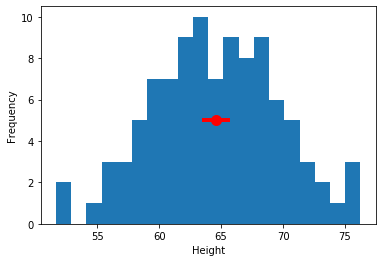

In [17]:
sample_size = 100
heights = np.random.normal(POPULATION_MU, POPULATION_SIGMA, sample_size)
SE = np.std(heights) / np.sqrt(sample_size)
(l, u) = stats.norm.interval(0.95, loc=np.mean(heights), scale=SE)

print (l, u)

plt.hist(heights, bins=20)
plt.xlabel('Height')
plt.ylabel('Frequency')

# Just for plotting
y_height = 5
plt.plot([l, u], [y_height, y_height], '-', color='r', linewidth=4, label='Confidence Interval')
plt.plot(np.mean(heights), y_height, 'o', color='r', markersize=10);

## 错误校准和违反假设

标准偏差、标准误差和置信区间的计算都依赖于一定的假设。如果违反了这些假设，那么95%置信区间在95%的情况下不一定包含总体参数。我们说，在这种情况下，置信区间是错误校准的。这里有一个例子。

### Example: 自相关数据

如果您的数据生成过程是自相关的，那么对标准偏差的估计将是错误的。这是因为自相关过程比正态分布过程产生更多的极值。这是由于新值依赖于以前的值，已经离均值很远的序列可能会离均值更远。为了检查这一点，我们将根据以下过程生成一些自相关数据。

$$X_t = \theta X_{t-1} + \epsilon$$
$$\epsilon \sim \mathcal{N}(0,1)$$

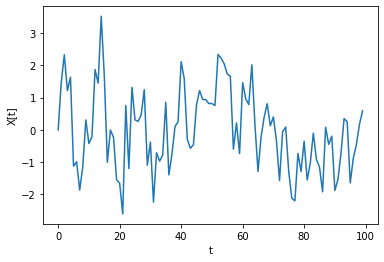

In [18]:
def generate_autocorrelated_data(theta, mu, sigma, N):
    # Initialize the array
    X = np.zeros((N, 1))
    
    for t in range(1, N):
        # X_t = theta * X_{t-1} + epsilon
        X[t] = theta * X[t-1] + np.random.normal(mu, sigma)
    return X

X = generate_autocorrelated_data(0.5, 0, 1, 100)

plt.plot(X);
plt.xlabel('t');
plt.ylabel('X[t]');

对于更大的样本容量，你会看到样本均值渐近收敛于0。这是因为过程仍然以0为中心，但我们来检查一下是否正确。我们将改变绘制样本的数量，并在增加样本容量时寻找收敛性。

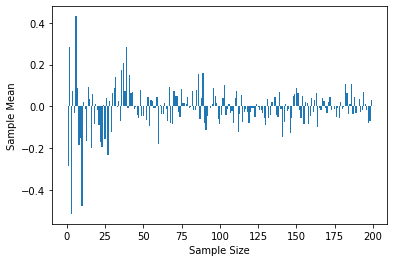

In [19]:
sample_means = np.zeros(200-1)
for i in range(1, 200):
    X = generate_autocorrelated_data(0.5, 0, 1, i * 10)
    sample_means[i-1] = np.mean(X)
    
plt.bar(range(1, 200), sample_means);
plt.xlabel('Sample Size');
plt.ylabel('Sample Mean');

显然有收敛性，我们还可以检验样本均值。

In [20]:
np.mean(sample_means)

-0.008571996202976648

非常接近于零。我们也可以象征性地推出均值为0，但假设我们已经用简单的经验分析说服了自己。现在我们知道了总体均值，我们可以检查置信区间的校准。首先，我们将编写两个辅助函数来计算某个输入数据的初始区间，并检查该区间是否包含真正的均值0。

In [21]:
def compute_unadjusted_interval(X):
    T = len(X)
    # Compute mu and sigma MLE
    mu = np.mean(X)
    sigma = np.std(X)
    SE = sigma / np.sqrt(T)
    # Compute the bounds
    return stats.norm.interval(0.95, loc=mu, scale=SE)

# We'll make a function that returns true when the computed bounds contain 0
def check_unadjusted_coverage(X):
    l, u = compute_unadjusted_interval(X)
    # Check to make sure l <= 0 <= u
    if l <= 0 and u >= 0:
        return True
    else:
        return False

现在我们要做很多试验，每次我们都要抽样一些数据，计算一个置信区间，然后检查置信区间是否包含总体均值。我们会持续记录，如果间隔时间被正确校准，我们应该会看到95%的试验成功。

In [22]:
T = 100
trials = 500
times_correct = 0
for i in range(trials):
    X = generate_autocorrelated_data(0.5, 0, 1, T)
    if check_unadjusted_coverage(X):
        times_correct += 1
    
print('Empirical Coverage: ', times_correct/float(trials)) 
print('Expected Coverage: ', 0.95) 

Empirical Coverage:  0.732
Expected Coverage:  0.95


显然报道是错误的。在这种情况下，我们需要对我们的标准误差估计进行所谓的新韦斯特修正来解释自相关。在实践中，检查你所做的假设是很重要的。检查您的数据是否是固定的(这意味着不存在自相关)是快速和容易的，而且这样做可以为您省去很多痛苦。像`Jarque Bera`这样的正态性测试也是一个好主意，因为它可以检测到某些可能违反许多后续统计分析假设的分布特性。